In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import pickle

In [4]:
sns.__version__

'0.11.0.rc0'

In [5]:
def load_pickle(fname):
    return pickle.load(open(fname, 'rb'))

In [6]:
def nx_to_igraph(nx_g) -> ig.Graph:
    """
    Convert networkx graph to an equivalent igraph Graph
    attributes are stored as vertex sequences
    """
    nx_g = nx.convert_node_labels_to_integers(nx_g, label_attribute='old_label')
    old_label = nx.get_node_attributes(nx_g, 'old_label')

    weights = nx.get_edge_attributes(nx_g, name='wt')  # WEIGHTS are stored in WT
    if len(weights) == 0:
        is_weighted = False
        edge_list = list(nx_g.edges())
    else:
        is_weighted = True
        edge_list = [(u, v, w) for (u, v), w in weights.items()]

    is_directed = nx_g.is_directed()
    ig_g = ig.Graph.TupleList(edges=edge_list, directed=is_directed,
                              weights=is_weighted)

#     logging.error(f'iGraph: n={ig_g.vcount()}\tm={ig_g.ecount()}\tweighted={is_weighted}\tdirected={is_directed}')

    for v in ig_g.vs:
        v['name'] = str(old_label[v.index])  # store the original labels in the name attribute
        v['label'] = str(v['name'])

    return ig_g

In [7]:
def make_rows(graphs, trial, model, dataset):
    rows = []
    for i, g in enumerate(graphs):
        gen = i + 1
        ig_g = nx_to_igraph(g)
        row = {'dataset': dataset, 'model': model, 'trial': trial, 'gen': gen,
               'n': g.order(), 'm': g.size(),
               'CC': ig_g.transitivity_avglocal_undirected(mode='zero'), 
               'APL': ig_g.average_path_length()}
        rows.append(row)
    return pd.DataFrame(rows)

In [ ]:
%%time
datasets = ['eucore', 'tree', 'clique-ring-500-4', 'flights', 'chess']
models = ['CNRG', 'SBM', 'Chung-Lu', 'BUGGE', 'SBM', 'Erdos-Renyi', 'GCN_AE', 'Kronecker']
trial = 1

dfs = []
for dataset in datasets[2: ]:
    for model in models[-2: ]:
        print(f'Reading {dataset!r} {model!r}')
        graphs = load_pickle(f'/data/infinity-mirror/buckets/bucket1/{dataset}/{model}/list_20_{trial}.pkl.gz')
        dfs.append(make_rows(graphs=graphs, trial=trial, model=model, dataset=dataset))

main_df = pd.concat(dfs, ignore_index=True)

Reading 'clique-ring-500-4' 'GCN_AE'
Reading 'clique-ring-500-4' 'Kronecker'
Reading 'flights' 'GCN_AE'
Reading 'flights' 'Kronecker'
Reading 'chess' 'GCN_AE'


In [ ]:
main_df.loc[(main_df.gen==1),'model'] = 'original'

In [ ]:
main_df.to_csv('apl_cc_rows_gcn_kron_rest.csv', index=False)

In [8]:
df1 = pd.read_csv('./apl_cc_rows_gcn_kron.csv')
df2 = pd.read_csv('./apl_cc_rows.csv')

In [9]:
main_df = pd.concat([df1, df2], ignore_index=True)

In [10]:
main_df

,dataset,model,trial,gen,n,m,CC,APL
0,eucore,original,1,1,986,16064,0.407050,2.586934
1,eucore,GCN_AE,1,2,986,219872,0.641749,1.547220
2,eucore,GCN_AE,1,3,986,242433,0.772586,1.502738
3,eucore,GCN_AE,1,4,986,242132,0.776862,1.504237
4,eucore,GCN_AE,1,5,986,241625,0.785633,1.508790
...,...,...,...,...,...,...,...,...
709,tree,Erdos-Renyi,1,17,2955,3098,0.000000,10.325203
710,tree,Erdos-Renyi,1,18,2955,2998,0.000000,10.393912
711,tree,Erdos-Renyi,1,19,2955,3000,0.000236,10.198253
712,tree,Erdos-Renyi,1,20,2955,2988,0.001327,10.215319


In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim((0.01, 300))
ax.set_xlim((0.00001, 1.25))
sns.scatterplot(x='CC', y='APL', hue='model', style='dataset', size='gen', sizes=(200, 10),
                alpha=0.5, data=main_df);

In [ ]:
sns.kdeplot?

In [13]:
no_cr = main_df[main_df.dataset != 'clique-ring-500-4']

/home/jupyter-ssikdar/miniconda3/envs/infinity-mirror/lib/python3.7/site-packages/seaborn/distributions.py:1183: UserWarning: No contour levels were found within the data range.
  **contour_kws,


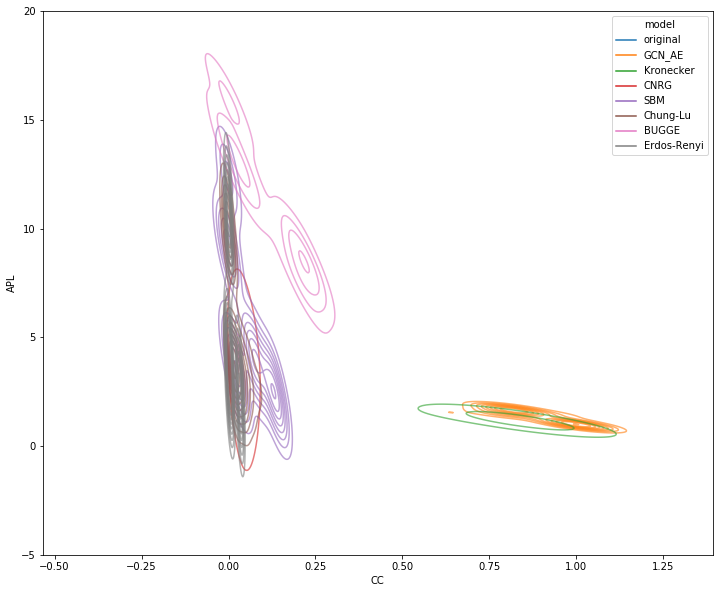

In [25]:
plt.rcParams['figure.figsize'] = (12, 10)
# KDE plots
# kron = no_cr.loc[main_df.model=='Kronecker']
# cnrg = no_cr.loc[main_df.model=='CNRG']


ax = sns.kdeplot(x='CC', y='APL', data=no_cr, hue='model', thresh=0.1, alpha=0.6)
ax.set_ylim((-5, 20));
# ax = sns.kdeplot(cnrg.CC, cnrg.APL,
#                  cmap="Blues", shade=True, shade_lowest=False)

In [16]:
sns.kdeplot?

In [ ]:
main_df

# Example plot -- figure 2 -- on 3 comm

In [5]:
orig_g = nx.random_partition_graph?

In [38]:
orig_g = nx.random_partition_graph([45, 35, 20], p_in=0.25, p_out=0.0075, seed=1)

In [46]:
# pos = nx.spring_layout(orig_g)
pos = nx.nx_agraph.graphviz_layout(orig_g, prog='neato')

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

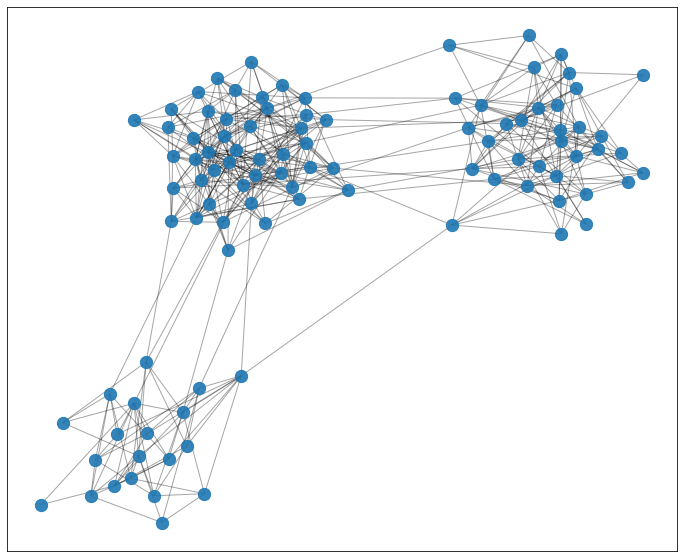

In [45]:
plt.rcParams['figure.figsize'] = (12, 10)

nx.draw_networkx_edges(orig_g, pos=pos, alpha=0.35, min_source_margin=5000, min_target_margin=5000);
nx.draw_networkx_nodes(orig_g, pos=pos, node_size=150, alpha=0.9);
# nx.draw_networkx(orig_g, pos=pos, with_labels=False, node_size=200, alpha=0.6,
#                 min_source_margin=100, min_target_margin=100)

In [34]:
nx.draw_networkx_edges?